<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Обзор-модели" data-toc-modified-id="Обзор-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обзор модели</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

## Подготовка

### Загрузка и обзор данных

In [43]:
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('taxi.csv')

In [44]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [45]:
df.shape

(26496, 2)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные даны с шагом 10 минут, пропусков нет, тип правильный.

### Подготовка данных

Вначале приведем столбец datetime к правильному типу данных, и сделаем его индексным.

In [47]:
df = df.set_index(pd.to_datetime(df.datetime, format="%Y-%m-%d %H:%M:%S")).drop(['datetime'], axis=1)

In [48]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим на монотонность

In [49]:
df.index.is_monotonic

True

Взглянем на данные

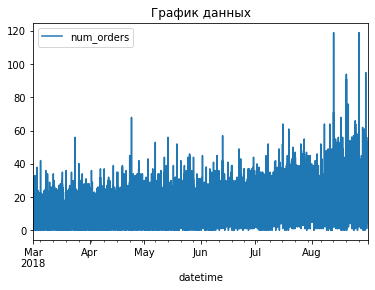

In [50]:
df.plot().set_title('График данных');

### Ресемплирование

Выполним ресемплирование данных по 1 часу, посчитаем сумму заказов в час.

In [51]:
df = df.resample('1H').sum()

In [52]:
df.shape

(4416, 1)

In [53]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


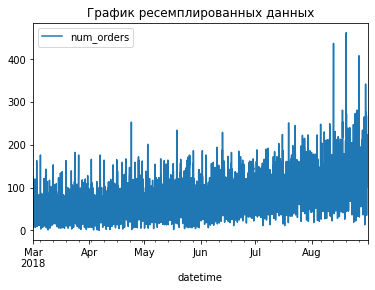

In [54]:
df.plot().set_title('График ресемплированных данных');

## Анализ

Взглянем на данные поближе, выберем первые 5 дней

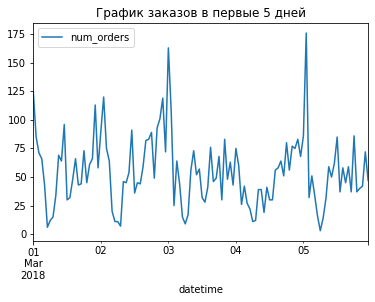

In [55]:
df['2018-03-01': '2018-03-5'].plot().set_title('График заказов в первые 5 дней');

К ночи количество заказов растет, к утру падает, днем примерно стабильно. Шум, вероятно, связан с прибытиями самолетов.

Разложим на тренды и сезонность, чтобы посмотреть подробнее.

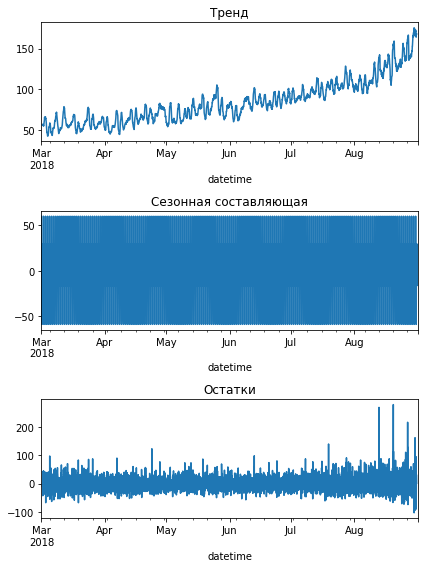

In [56]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

С сезонным трендом не совсем ясно, рассмотрим поближе.

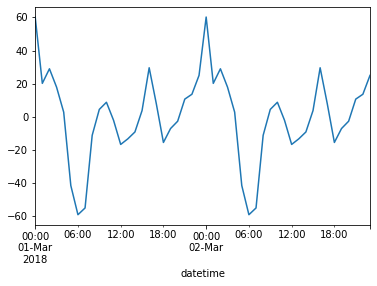

In [57]:
decomposed.seasonal['2018-03-01': '2018-03-2'].plot();

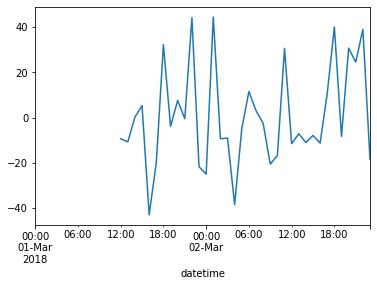

In [58]:
decomposed.resid['2018-03-01': '2018-03-2'].plot();

В целом, мы видим, что количество заказов к лету растет.

Остатки по амплитуде выше получившейся сезонной составляющей. Значит, тренд роста количества заказов от утра к ночи и падению к утру слабее, чем, например, прилеты самолетов.

Заметен суточный цикл, в 6 утра заказов меньше всего, в 00 больше всего.

In [59]:
df_ = df.copy()
df_['mean'] = df_['num_orders'].rolling(24).mean()
df_['std'] = df_['num_orders'].rolling(24).std()

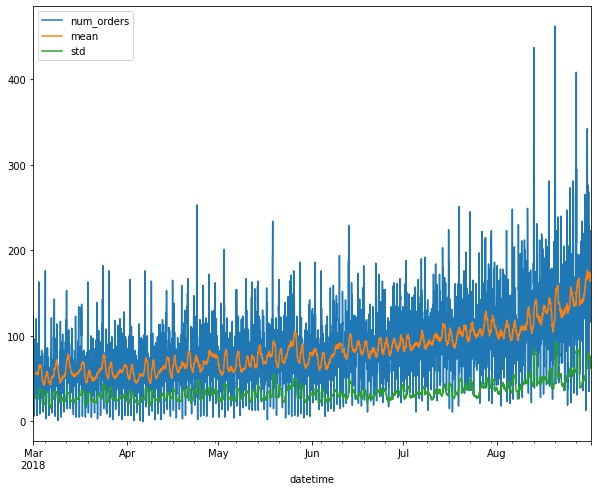

In [60]:
df_.plot(figsize=(10, 8));

По графику скользяцего среднего подтверждается рост заказов к лету.

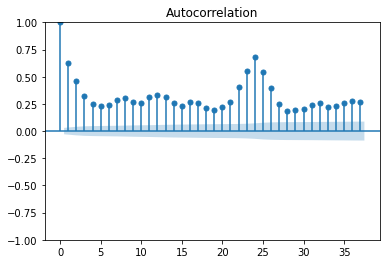

In [61]:
plot_acf(df)
plt.show()

График автокорреляции подтверждает наличие суточной составляющей, а то, что она постоянно положительная - наличие тренда.

## Обучение

Вначале создадим побольше признаков.

### Создание признаков

In [62]:
def make_features(data, lag_start, lag_end, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(lag_start, lag_end + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [63]:
df_big = make_features(df, 1, 24, 24)

In [64]:
df_big.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df_big.shape

(4416, 29)

### Разделение на выборки

In [66]:
train_valid, test = train_test_split(df_big, shuffle=False, test_size=0.1)

print(train_valid.index.min(), train_valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [67]:
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())

2018-03-01 00:00:00 2018-07-27 23:00:00
2018-07-28 00:00:00 2018-08-13 13:00:00


In [68]:
train = train.dropna()

feature_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

feature_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

feature_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Линейная регрессия

In [69]:
lr_model = LinearRegression()

lr_model.fit(feature_train, target_train);

In [70]:
pred_valid = lr_model.predict(feature_valid)

print('RMSE обучающей выборки:', mean_squared_error(target_valid, pred_valid) ** .5)

RMSE обучающей выборки: 34.136280205461254


### Случайный лес

In [71]:
test_rf = pd.DataFrame(columns=['n_estimators', 'max_depth', 'rmse'])

for est in tqdm(range(20, 120, 20)):
    for depth in range(10, 50, 10):
        rf_model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=0)
        rf_model.fit(feature_train, target_train)
        rf_pred = rf_model.predict(feature_valid)
        test_rf = test_rf.append(
            pd.DataFrame([[est, depth, mean_squared_error(target_valid, rf_pred) ** .5]],
            columns=['n_estimators', 'max_depth', 'rmse']), ignore_index=True
        )

100%|██████████| 5/5 [00:51<00:00, 10.36s/it]


In [72]:
test_rf.sort_values(by='rmse', ascending=True)

,n_estimators,max_depth,rmse
19,100,40,33.466803
18,100,30,33.467678
17,100,20,33.568385
13,80,20,33.582669
15,80,40,33.613182
14,80,30,33.614616
10,60,30,33.686452
11,60,40,33.721707
9,60,20,33.741826
16,100,10,33.801592


Выбираем гиперпараметры `n_estimators = 100`, `max_depth = 40`.	

In [73]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=40, random_state=0)

In [74]:
rf_model.fit(feature_train, target_train);

In [75]:
pred_valid = rf_model.predict(feature_valid)

print('RMSE обучающей выборки:', mean_squared_error(target_valid, pred_valid) ** .5)

RMSE обучающей выборки: 33.46680276687909


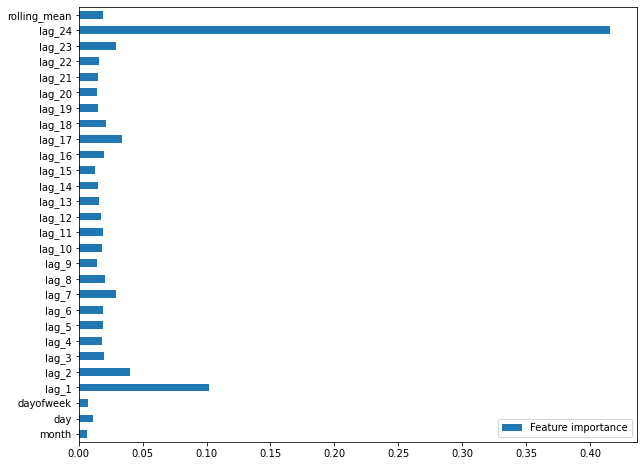

In [76]:
(
    pd.DataFrame(
        rf_model.feature_importances_,
        index=feature_train.columns,
        columns=['Feature importance']
    ).plot(kind='barh', figsize=(10, 8))
);

**Вывод:** выбираем RF модель, так как ее RMSE на обучающей выборке значительно меньше.

## Тестирование

Для более точного предсказания нам придется объединить валидационную и обучающую выборки, ведь прогноз зависит от предыдущих значаний очень сильно, а в валидационной выборке мы убрали большую часть значений, близких к тестовым.

In [77]:
train, test = train_test_split(df_big, shuffle=False, test_size=0.1)

train = train.dropna()

feature_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

feature_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [79]:
rf_model.fit(feature_train, target_train);

In [80]:
pred_test = rf_model.predict(feature_test)
print('RMSE тестовой выборки:', mean_squared_error(target_test, pred_test) ** .5)

RMSE тестовой выборки: 43.905131712864524


**Вывод:** RMSE RF модели на тестовой выборке `RMSE = 43.91`, что ниже требуемого значения.

Проверим, что будет, если мы предскажем медианой или предыдущим значением.

In [37]:
pred_median = np.ones(test.shape) *  train['num_orders'].median()

print('RMSE:', mean_squared_error(pred_median, test) ** .5)

RMSE: 85.5164440667252


In [38]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', mean_squared_error(test, pred_previous) ** .5)

RMSE: 55.29777630332717


**Вывод:** модель прошла проверку на адекватность.

### Обзор модели

Посмотрим на то, как модель предсказывает данные: построим график тестового интервала и предсказаний модели.

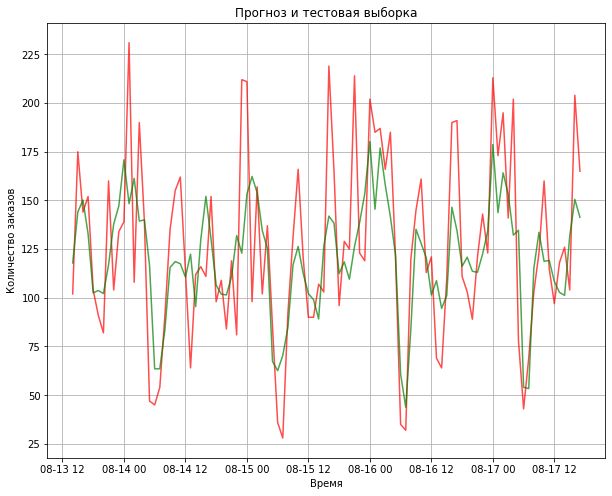

In [85]:
ax, fig = plt.subplots(figsize=(10, 8))

ax = plt.plot(test.index[:100], target_test[:100], color = 'red', alpha=0.7)
ax = plt.plot(test.index[:100], pred_test[:100], color = 'green', alpha=0.7)
 
plt.title('Прогноз и тестовая выборка')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
 
plt.grid()
plt.show()

Неплохо получилось, отдельные выбросы, конечно, не предсказываются, но в целом тренд соблюдается.

## Вывод

Изучили данные, провели ресемплирование, выделили тренд и сезонные (дневные) циклы. Создали дополнительные признаки: среднее, месяц, день, день недели, сдвиги между данными.
С помощью RF модели с подобранными гиперпараметрами получили предсказания с метрикой RMSE на тетовой выборке 43.91.